This kernel will build RFECV from first principlies, and take you through the process of selecting these subsets of features. I will also show the practical way to implement it using the in-built fuction scikit.model_selection.RFECV, and discuss the precautions needed when using this technique.

As the main focus of the kernel is showcasing RFECV, the common steps of EDA, data cleaning, feature engineering and encoding will NOT be focused on. The following cell is my own personal processing of the datasets, though I encourage you to follow your own methods and adjust my transformations to your own when you explore this kernel.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

train = pd.read_csv("/kaggle/input/titanic/train.csv")

# Fill Null Values
train["Fare"].fillna(train["Fare"].median(), inplace = True)
train["Embarked"].fillna(train["Embarked"].mode(), inplace = True)
age_avg, age_std = train["Age"].mean(), train["Age"].std()
random_values = np.random.normal(age_avg, age_std, size=len(train))
train["Age"].fillna(pd.Series(random_values), inplace=True)
train["Age"] = np.ceil(train["Age"]).astype(int)

# Create FamSize and IsAlone variables
train["FamSize"] = train["SibSp"] + train["Parch"] + 1
train["IsAlone"] = 0
train.loc[train["FamSize"] == 1, "IsAlone"] = 1
    
# Categorise "continuous" variables
train["CatAge"] = pd.cut(train["Age"], bins=pd.cut(train["Age"], bins=5).cat.categories).cat.codes
train["CatFare"] = pd.cut(train["Fare"], bins=pd.qcut(train["Fare"], q=5).cat.categories).cat.codes
train["CatFare"] = train["CatFare"].replace(-1, 4) # few rounding errors with cut function
   
# For Sex use Label Encoding
train["Sex_Code"] = train["Sex"].map({"female": 0, "male": 1})

# For Embarked use One Hot Encoding
train[["Embarked_C", "Embarked_Q", "Embarked_S"]] = pd.get_dummies(train["Embarked"]).astype(int)

In [2]:
x_var = ["Pclass", "SibSp", "FamSize", "IsAlone", "Parch", "CatAge", "CatFare",
         "Sex_Code", "Embarked_C", "Embarked_Q", "Embarked_S"]

y_var = ["Survived"]

train[x_var + y_var]

,Pclass,SibSp,FamSize,IsAlone,Parch,CatAge,CatFare,Sex_Code,Embarked_C,Embarked_Q,Embarked_S,Survived
0,3,1,2,0,0,1,0,1,0,0,1,0
1,1,1,2,0,0,2,4,0,1,0,0,1
2,3,0,1,1,0,2,1,0,0,0,1,1
3,1,1,2,0,0,2,4,0,0,0,1,1
4,3,0,1,1,0,2,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,1,1,0,2,2,1,0,0,1,0
887,1,0,1,1,0,1,3,0,0,0,1,1
888,3,1,4,0,2,2,3,0,0,0,1,0
889,1,0,1,1,0,2,3,1,1,0,0,1


Now we have a processed dataset which we can investigate feature elimination on. For our exploration, let us use a Decision Tree as our base model. This can be replaced by whichever model you wish to optimise the selected features for.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

model = DecisionTreeClassifier(random_state = 0)
#model = XGBClassifier(seed=0)

X = train[x_var]
y = train[y_var]

# Building RFECV: From the Ground Up
</br>
Break down the goal of RFECV: To choose the best subset of features for your dataset and model. But how do we even define a "best" feature?
</br>

## Feature Importances

Some may have the idea to use the *feature_importances*_ attribute that is available for many ML algorithms. These feature importances are calculated differently depending on the chosen algorithm, but the final output is always the same: an array containing an importance score for each feature in your dataset. **This concept is the basis of RFECV.**

In [4]:
model.fit(X, y)
pd.DataFrame({"Features": X.columns, "Importances": model.feature_importances_})

,Features,Importances
0,Pclass,0.178116
1,SibSp,0.025615
2,FamSize,0.078088
3,IsAlone,0.018977
4,Parch,0.022033
5,CatAge,0.117135
6,CatFare,0.075376
7,Sex_Code,0.431625
8,Embarked_C,0.021772
9,Embarked_Q,0.008177


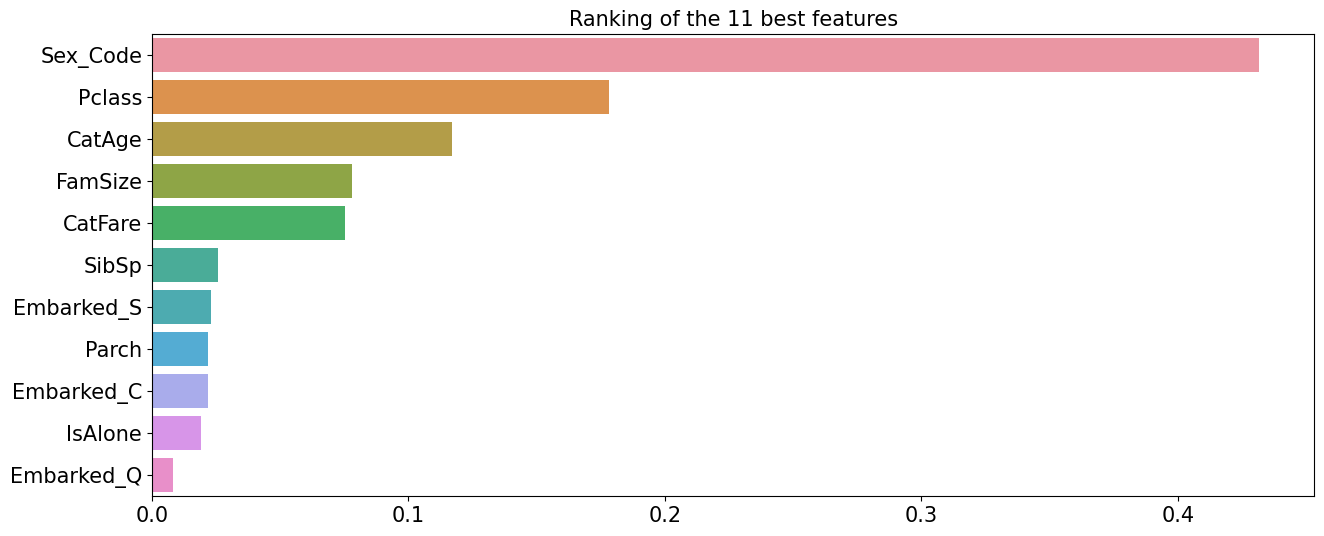

In [5]:
def plot_feature_importances(feat, feat_import):
    """Plot feature importance scores against features"""
    df = pd.DataFrame({"Features": feat, "Importances": feat_import})
    plt.figure(figsize=(15, 6))
    sns.barplot(x="Importances", y="Features", data = df.sort_values("Importances", ascending=False))

    plt.xlabel("")
    plt.ylabel("")
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.title(f"Ranking of the {len(feat)} best features", size=15)

    plt.show()

model.fit(X, y)    
plot_feature_importances(X.columns, model.feature_importances_)

However, this ranking is somewhat deceptive as **the top 4 features in these rankings are not necessarily the best 4 features.**

What does this mean? From the above graph, we infer that the best 4 features are:
1. Sex_Code
2. Pclass
3. CatAge
4. FamSize

So let us try fitting our model on just these 4 best features. Our data and model are staying the same, so the rankings should be the same right?

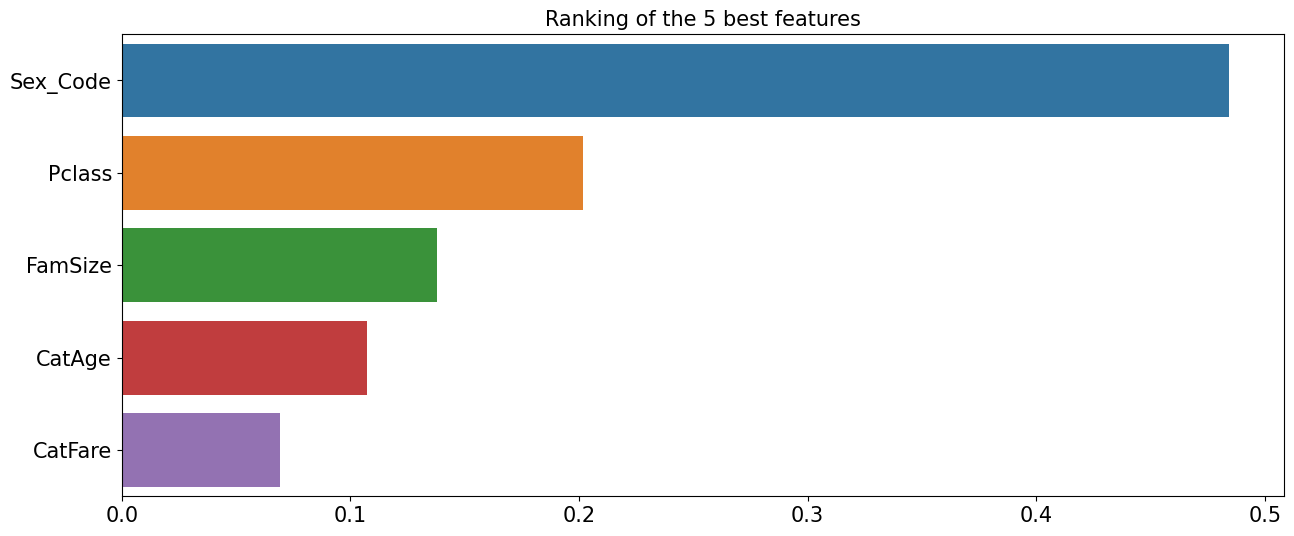

In [6]:
X_sub = X[["Sex_Code", "Pclass", "FamSize", "CatAge", "CatFare"]]

model.fit(X_sub, y)
plot_feature_importances(X_sub.columns, model.feature_importances_) # defined in previous hidden cell

After taking a subset of the best 4 features in the original graph, now the ordering of number 3 and 4 have switched. 

1. Sex_Code
2. Pclass
3. FamSize
4. CatAge

Why does the presence of other features affect the feature importance ranking? This is because feature importances are dependent on the predictive power of a feature. And this predictive power can vary based on its correlation with other features in the dataset. In our case, our feature "FamSize" was more important than "CatAge" when the top 4 features were included, but had dropped in the ranking with all 11 features included, since you already had the other features "SibSp" and "ParCh" which are correlated to "FamSize". The predictive power was in a way distributed to these other features "SibSp" and "ParCh".

The interaction between all the different features makes it hard to identify if one feature is better than another. This is a good starting point but we need a better way of ranking features which takes into account all the other features.

</br>

## Recursive Feature Elimination (RFE)

The RFE method iteratively identifies the most important features in a dataset by removing the least important feature in each iteration. The steps are:

1. Fit your model on the dataset
2. Call the feature importance ranking
3. Remove the lowest ranked feature
4. Repeat steps 1-3 until you reach desired number of "best" features

For example, the best 10 features are selected by calling the feature importance ranking and removing the lowest ranked feature. The best 9 features are selected by refitting your model on these 10 features, calling the feature importance ranking, and removing the lowest ranked feature among them.  <br> This is different from a simple feature importance ranking since we have seen previously that the lowest ranked feature may change after removing a feature and reranking.

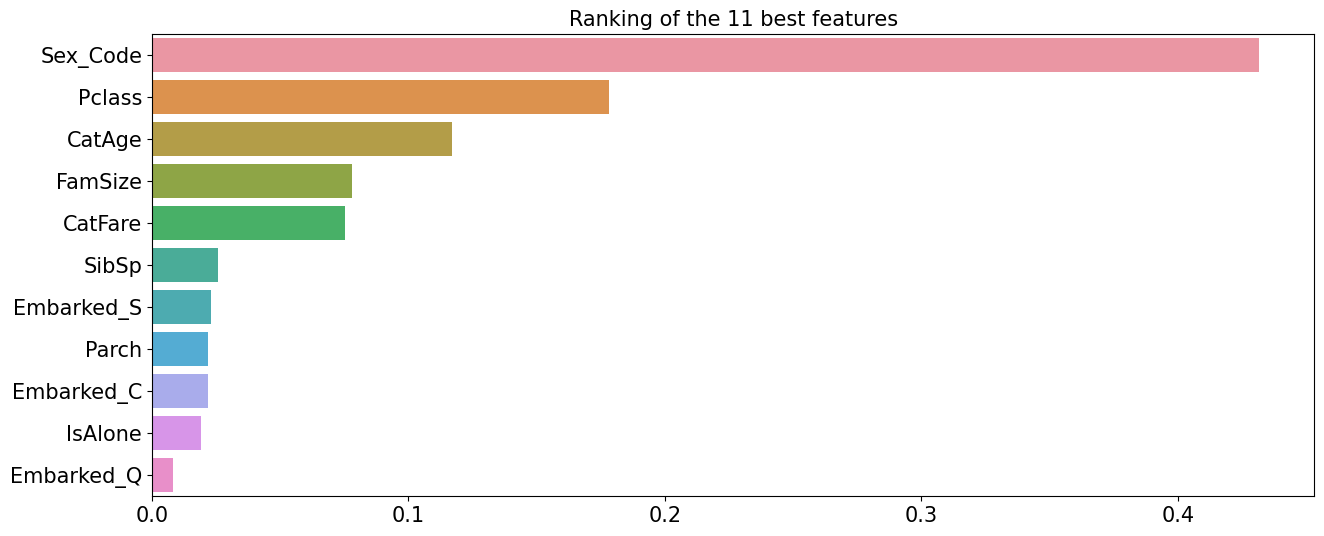

Removing: Embarked_Q
----------


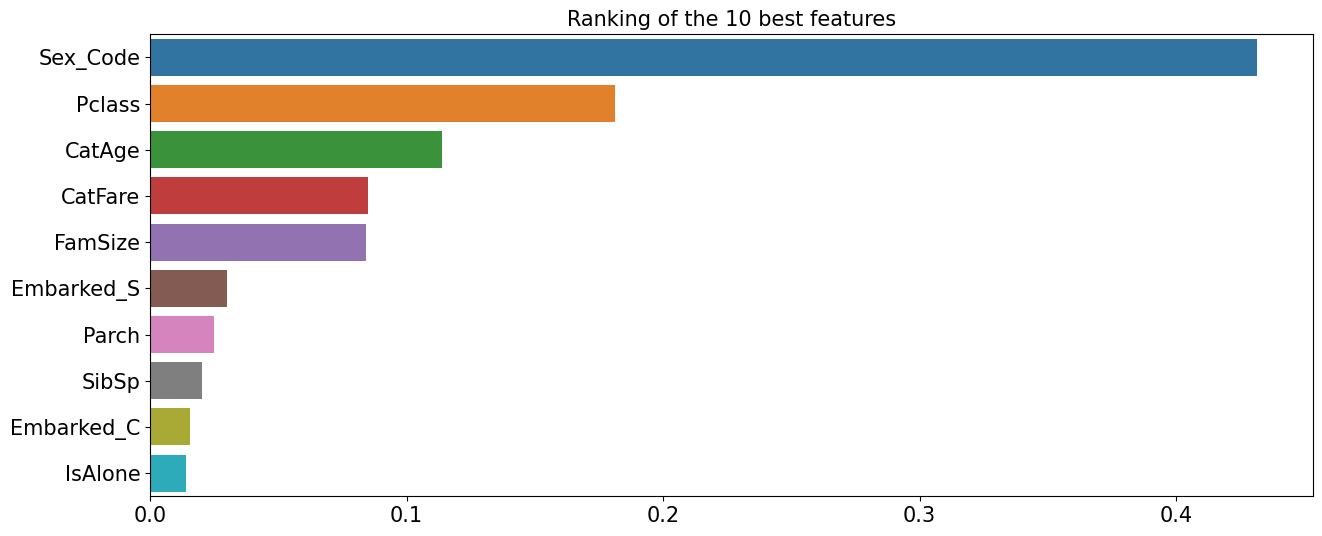

Removing: IsAlone
----------


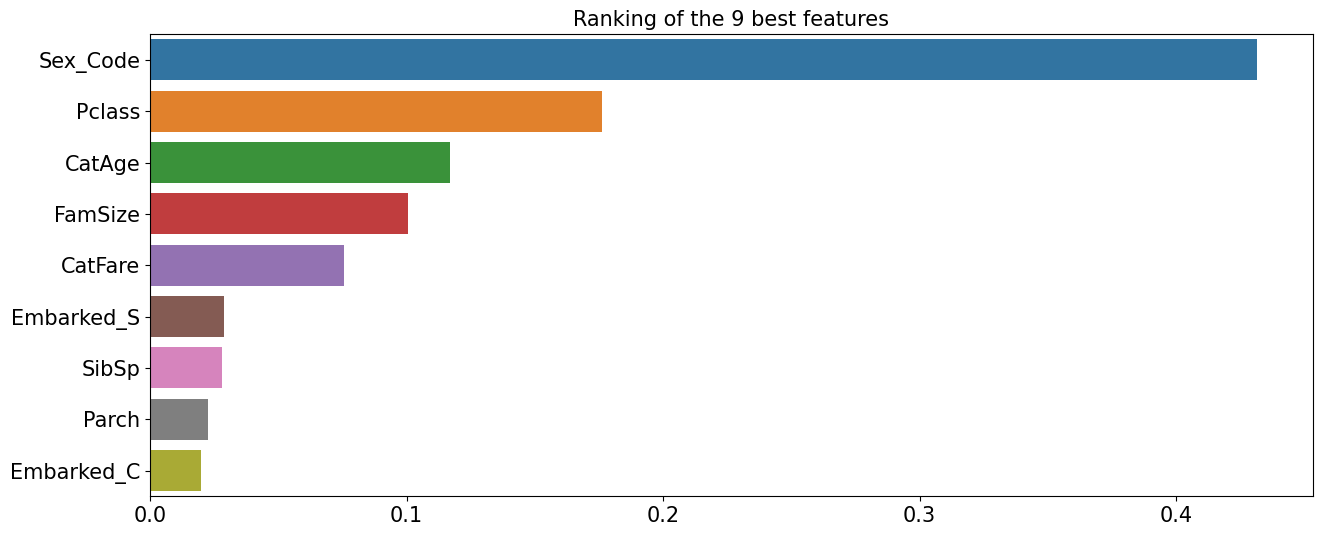

Removing: Embarked_C
----------


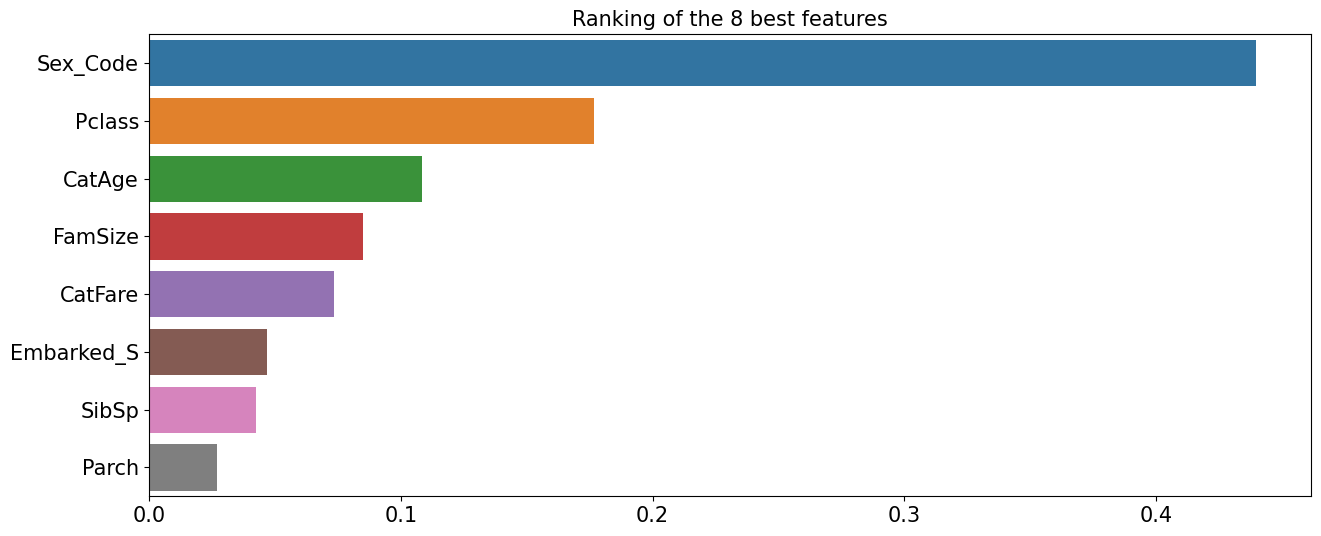

Removing: Parch
----------


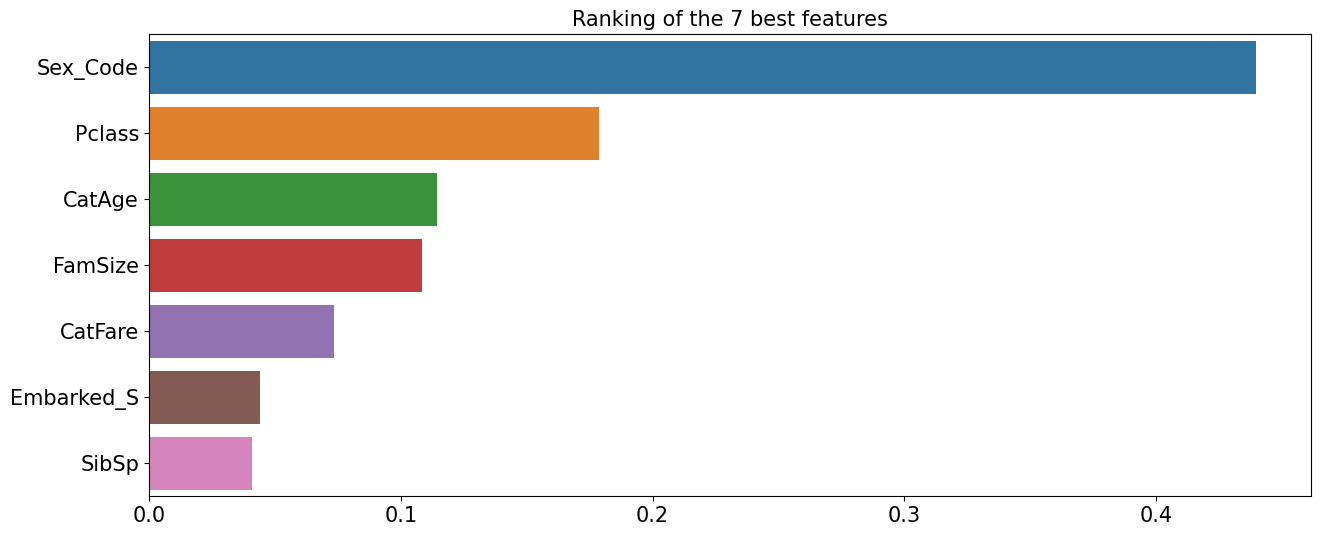

Removing: SibSp
----------


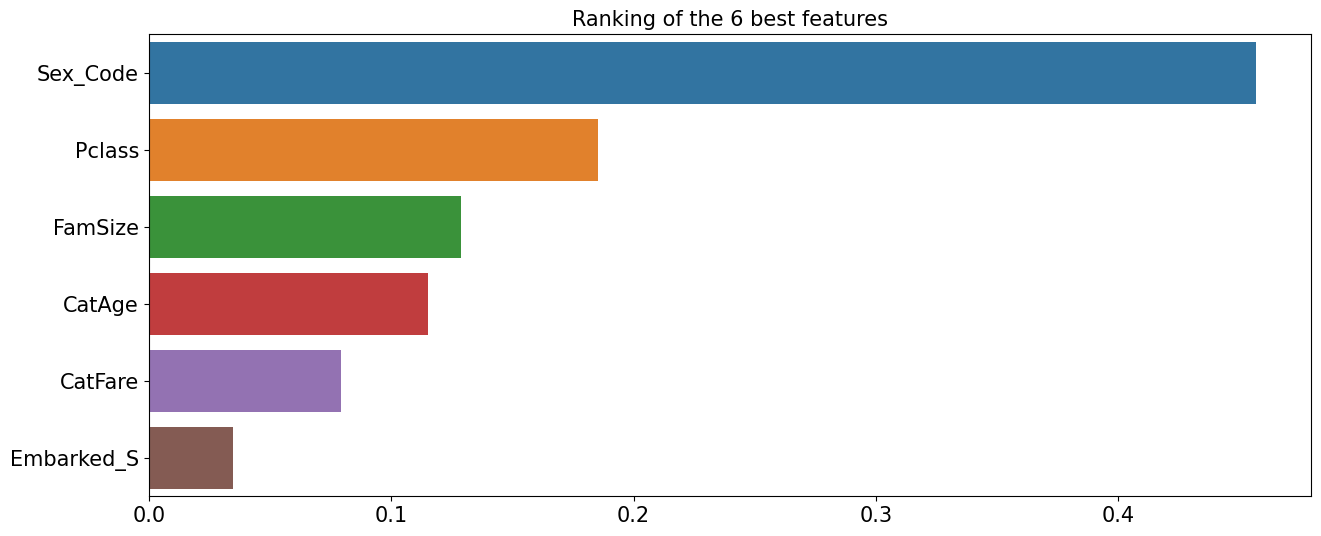

Removing: Embarked_S
----------


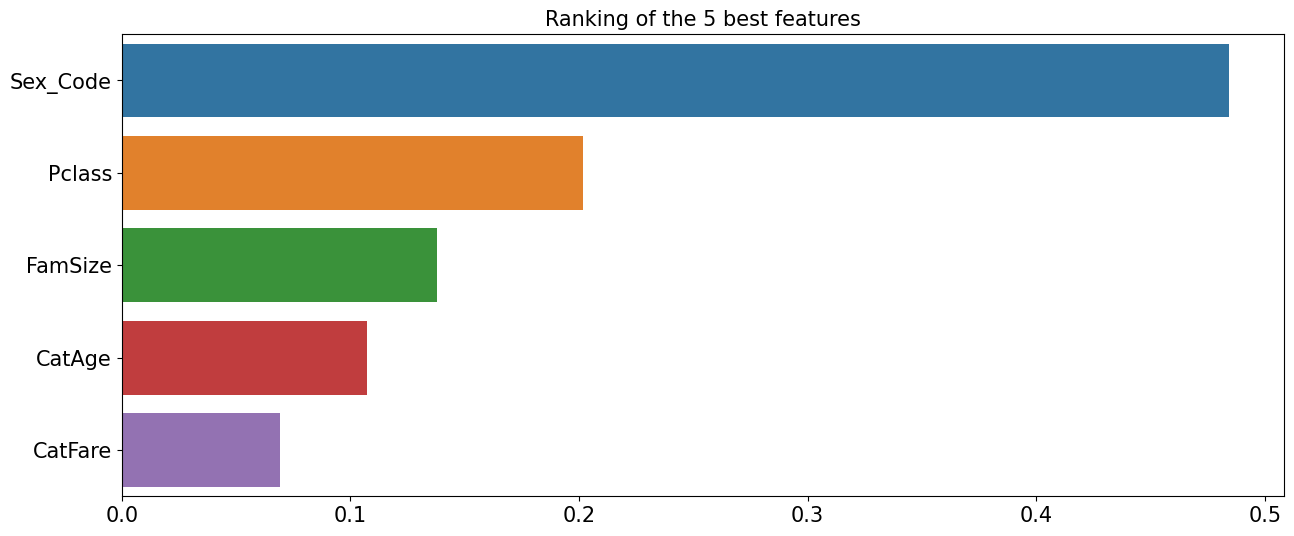

Removing: CatFare
----------


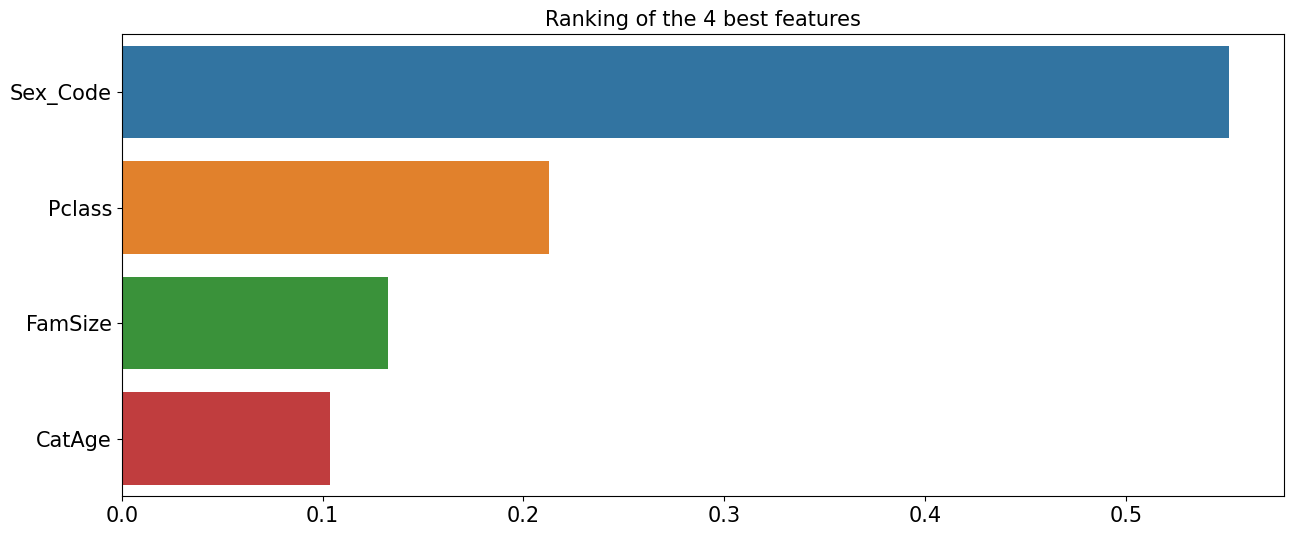

Removing: CatAge
----------


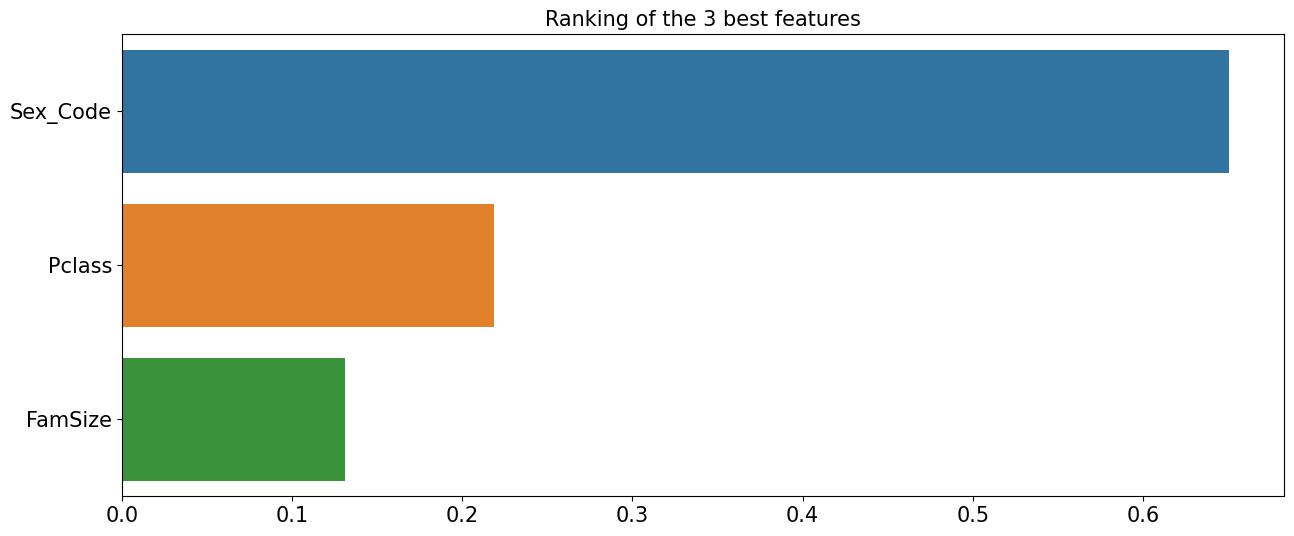

Removing: FamSize
----------


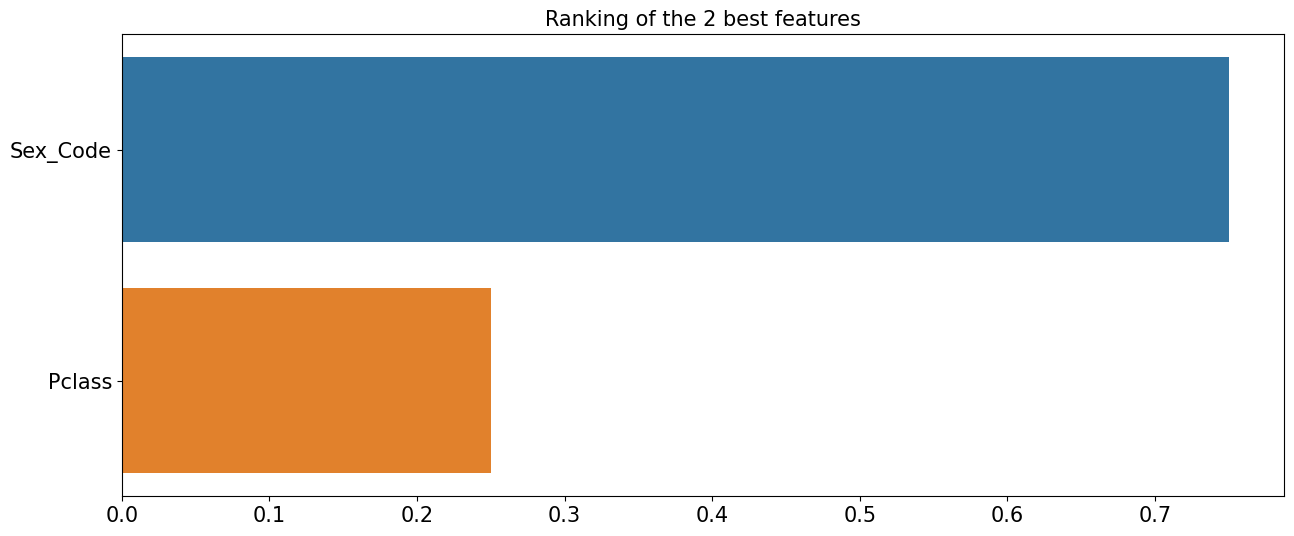

Removing: Pclass
----------


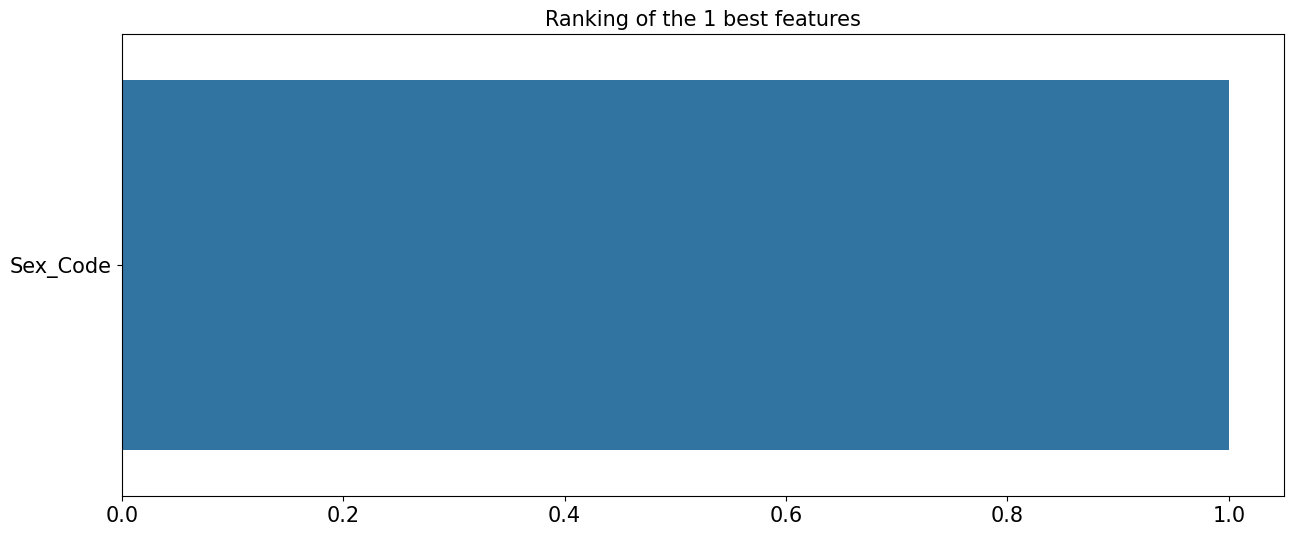

Removing: Sex_Code
----------


In [7]:
features = x_var.copy()

for _ in range(len(x_var)):
    model.fit(train[features], y)
    plot_feature_importances(features, model.feature_importances_)
    lowest_rank = features[np.argmin(model.feature_importances_)]
    print("Removing:", lowest_rank)
    features.remove(lowest_rank)
    print("-"*10)

**Observation:** These graphs again show an interesting pattern with feature "Embarked_S". This was the second lowest ranked feature in the third and fourth iteration, but managed to move higher after the reranking and ended up being the fifth feature removed. This is because by removing "Embarked_C" and "Embarked_Q" which are correlated variables, "Embarked_S" had gained more predictive power. 

We can use this to create a function stops at a certain iteration, which essentially selects the best "n" features.

In [8]:
def rfe_function(alg, X, y, n_features_to_select):
    features = list(X.columns)

    for _ in range(len(X.columns) - n_features_to_select):
        alg.fit(X[features], y)
        lowest_rank = features[np.argmin(alg.feature_importances_)]
        features.remove(lowest_rank)
    
    return features

We have developed a better method called RFE to rank all the feature importances and identify the best features! But how do we know how many features we should select for our model?  <br> Do we take the best 5 features? The best 10? We also need to devise a method to find the optimal number of features. 

One idea is to use a scoring metric in between each RFE iteration, and obtain a score for each number of features selected. This will help identify the point at which we are underfitting the model by removing too many features. However, since we have introduced a scoring metric, we need to be cautious of overfitting the model as well. We can address this the same way we generally address overfitting - by implementing cross-validation.

</br>

## Implementing Cross Validation

Recursive Feature Elimination with Cross-Validation (RFECV) is the technique obtained when we combine RFE and cross-validation.  <br> 
By identifying the number of features that consistently improve model performance over multiple folds, RFECV mitigates overfitting concerns.

The detailed process of RFECV is as follows:

1. Divide your dataset into different folds using a Cross-Validation Split.
2. Apply RFE with scoring on the first fold:
    1. Fit your model on the training data from the first fold.
    2. Evaluate the model's performance on the test data from the first fold using a chosen scoring metric.
    3. Obtain the feature importance ranking from the trained model.
    4. Remove the lowest ranked feature.
    5. Repeat steps A-D until all number of features have been iterated over to create an array of "Number of features vs Score."
3. Repeat step 2 for all other folds, ensuring each time you retrain on the training data and evaluate on the test data.
4. Average the model scores obtained from each fold and identify the optimal number of features that resulted in the highest average score.
5. Apply RFE once to the entire dataset using the optimal number of features:
    1. Refit your model onto the entire dataset.
    2. Obtain the feature importance ranking from the refitted model.
    3. Remove the lowest ranked feature.
    4. Repeat steps A-C until the number of features is equal to the optimal number of features.

</br>

**Step 1:** We will use a Stratified 5-fold CV split for our feature selection process. I have chosen only 5 folds since the size of the entire dataset is fairly small, and creating too many folds will make the size of the testing sets within each fold too small. We also have used a Stratified version since our target variable "Survived" is unbalanced, there are more casualties compared to survivors.

If you do not set a random_state to our cv_split, then you can potentially get slightly different results each time.

In [9]:
from sklearn.model_selection import StratifiedKFold

cv_split = StratifiedKFold(5, shuffle=True, random_state=0)

**Step 2:** Firstly, let us modify our previous function slightly so that it can retrieve a score upon each iteration. We can store this in the array "scores_array".

We have changed the function in 3 ways:

* Created a scores array to store the score for each number of features
* Created a way to update that scores array within the loop
* Set the n_features_to_select variable to 0, since we want the function to iterate over every possibile number of features

In [10]:
from sklearn.metrics import accuracy_score

def score(alg, x_train, x_test, y_train, y_test):
    """Calculate the accuracy score of the algorithm."""
    alg.fit(x_train, y_train)
    y_pred = alg.predict(x_test)
    return accuracy_score(y_test, y_pred)

def rfe_function2(alg, x_train, x_test, y_train, y_test):
    features = list(x_train.columns)
    scores_array = np.empty(len(features))
    for i in range(len(features)):
        # Define a scoring metric for the model
        scores = score(alg, x_train[features], x_test[features],
                       y_train, y_test)
        scores_array[-i-1] = scores
        
        # Remove lowest ranked feature
        alg.fit(x_train[features], y_train)
        lowest_rank = features[np.argmin(alg.feature_importances_)]
        features.remove(lowest_rank)
    
    return scores_array

**Step 3:** We should work seperately on each fold, and apply our new RFE function on each one. We can do this using a for loop over the cross validation split. Let us store the results for each fold in a dictionary "dic".

In [11]:
def rfecv_function(alg, X, y, cv):
    dic = {}
    for fold_index, (train_index, test_index) in enumerate(cv.split(X, y)):
            x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
            x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
            dic[f"split{fold_index}_test_score"] = rfe_function2(alg, x_train_fold, x_test_fold, y_train_fold, y_test_fold)
    return dic

fold_test_scores = rfecv_function(model, train[x_var], train[y_var], cv_split)
fold_test_scores

{'split0_test_score': array([0.82122905, 0.80446927, 0.81564246, 0.82681564, 0.8547486 ,
        0.82122905, 0.83240223, 0.84357542, 0.84916201, 0.84357542,
        0.83798883]),
 'split1_test_score': array([0.84831461, 0.80337079, 0.84831461, 0.84269663, 0.80337079,
        0.80898876, 0.81460674, 0.80898876, 0.80898876, 0.80337079,
        0.80337079]),
 'split2_test_score': array([0.79213483, 0.78089888, 0.79213483, 0.81460674, 0.80898876,
        0.79775281, 0.79775281, 0.79775281, 0.79213483, 0.79213483,
        0.79775281]),
 'split3_test_score': array([0.73033708, 0.73595506, 0.73595506, 0.74719101, 0.78651685,
        0.78651685, 0.7752809 , 0.7752809 , 0.78651685, 0.78089888,
        0.7752809 ]),
 'split4_test_score': array([0.74157303, 0.74157303, 0.75842697, 0.76404494, 0.76404494,
        0.75280899, 0.75842697, 0.75280899, 0.76404494, 0.76404494,
        0.76404494])}

**Step 4:** Average the test scores over all cross validation folds. We then identify the number of features with the highest averaged test score, and select that as the optimal number of features.

,Test Scores
Number of Features,
1,0.786718
2,0.773253
3,0.790095
4,0.799071
5,0.803534
6,0.793459
7,0.795694
8,0.795681
9,0.800169


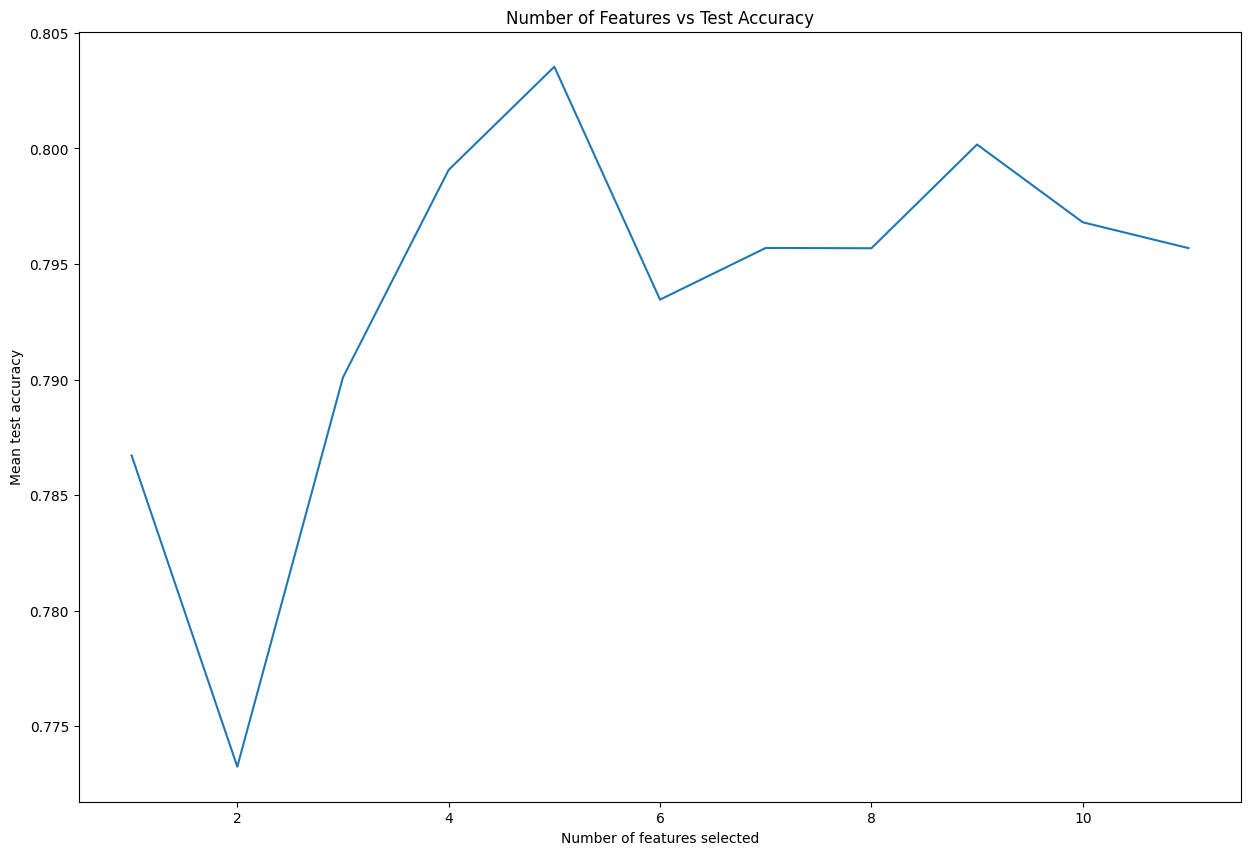

Optimal number of features: 5


In [12]:
mean_test_scores = np.mean(list(fold_test_scores.values()), axis=0)
n_scores = len(mean_test_scores)
display(pd.DataFrame({"Number of Features": range(1, n_scores + 1), "Test Scores": mean_test_scores}).set_index("Number of Features"))

# Visualise the scores in a line graph
plt.figure(figsize=(15,10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.plot(range(1, n_scores + 1), mean_test_scores)
plt.title("Number of Features vs Test Accuracy")
plt.show()

optimal_number_of_features = np.argmax(mean_test_scores) + 1
print(f"Optimal number of features: {optimal_number_of_features}")

**Step 5:** Now we have identified the optimal number of features that maximises the performance of our model, we can use the original RFE function we have previously defined to show which features were actually selected.

In [13]:
print(f"Selected features: {rfe_function(model, X, y, n_features_to_select = optimal_number_of_features)}")

Selected features: ['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code']


And with that step, we have completed RFECV and selected a subset of features to maximise our models performance!

</br>

# How to use RFECV from sklearn

That was a fairly long process of feature selection, so let's see the practical shortcut to implement this technique using sklearn. Here are some of the important parameters that you should understand:

**estimator:** The model for which you are optimising feature selection.

**step:** Number of features which are removed in each RFE iteration. We have tested this with a single step, but if there are many features in your dataset you can increase this to speed up the process.

**min_features_to_select:** Set a cap on the number of features that can be removed. We will not set any limit on the minimum number of features, so we set this to 1.

**cv:** The cross validation split used. Similar to the previous section, we will use the same Stratified 5-fold split.

**scoring:** The evaluation metric to score the test sets in each cross-validation fold. In the previous section we had used accuracy,and we will use the same here.

**n_jobs:** Number of cores used for the training process. If set to -1, all cores are used.

</br>

You can check out the official Sklearn decomentation for more information on parameters, attributes, and methods for the RFECV function: </br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

cv_split = StratifiedKFold(5, shuffle=True, random_state=0)

rfecv = RFECV(
    estimator=model,
    step=1,
    min_features_to_select=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Optimal features: {list(rfecv.get_feature_names_out())}")

Optimal number of features: 5
Optimal features: ['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code']


The attribute **.cv_results_** returns arrays of scores from each split, and also the aggregated (mean) scores over all folds in "mean_test_score". We have calculated both of these in the previous section, so we compare the sklearn method with the results we have obtained from the previous section.

In [15]:
rfecv.cv_results_

{'mean_test_score': array([0.78671772, 0.77325341, 0.79009478, 0.79907099, 0.80353399,
        0.79345929, 0.79569393, 0.79568138, 0.80016948, 0.79680497,
        0.79568765]),
 'std_test_score': array([0.04523577, 0.02944403, 0.03995085, 0.03696668, 0.03000562,
        0.02337265, 0.02651396, 0.03075529, 0.02840415, 0.02675301,
        0.02557491]),
 'split0_test_score': array([0.82122905, 0.80446927, 0.81564246, 0.82681564, 0.8547486 ,
        0.82122905, 0.83240223, 0.84357542, 0.84916201, 0.84357542,
        0.83798883]),
 'split1_test_score': array([0.84831461, 0.80337079, 0.84831461, 0.84269663, 0.80337079,
        0.80898876, 0.81460674, 0.80898876, 0.80898876, 0.80337079,
        0.80337079]),
 'split2_test_score': array([0.79213483, 0.78089888, 0.79213483, 0.81460674, 0.80898876,
        0.79775281, 0.79775281, 0.79775281, 0.79213483, 0.79213483,
        0.79775281]),
 'split3_test_score': array([0.73033708, 0.73595506, 0.73595506, 0.74719101, 0.78651685,
        0.78651685, 0

In [16]:
np.array_equal(mean_test_scores, rfecv.cv_results_["mean_test_score"])

True

NOTE: previous versions of scikit have used rfecv.grid_scores_ instead of rfecv.cv_results_["mean_test_score"] but this has been depreciated and you should use the latter instead.

In [17]:
# Check results within each fold is equal to our previous variable fold_test_scores
results2 = {key: rfecv.cv_results_[key] for key in list(rfecv.cv_results_.keys())[2:]}
all(np.array_equal(fold_test_scores[key], results2[key]) for key in fold_test_scores)

True

Let us visualise these test scores from the in-built method similar what we did in the previous section, and find identical results for "Number of Features vs Test Scores". In this graph we have also added a background fill to cover one standard deviation away from the mean test scores.

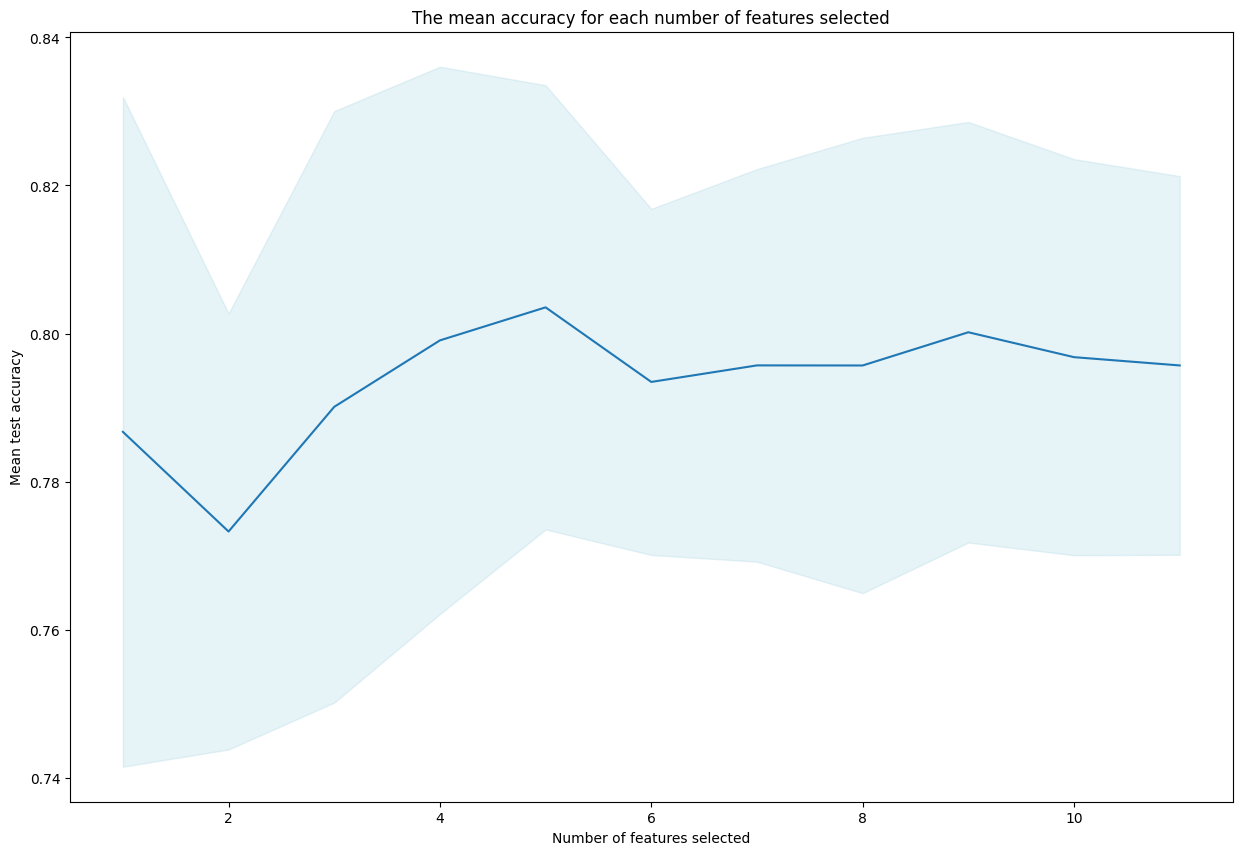

In [18]:
def plot_features_vs_cvscore(rfecv_model):
    n_features = len(rfecv_model.cv_results_["mean_test_score"])
    plt.figure(figsize = (15,10))
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.plot(range(1, n_features + 1), rfecv_model.cv_results_["mean_test_score"])
    plt.fill_between(range(1, n_features + 1), 
                     rfecv_model.cv_results_["mean_test_score"] - rfecv_model.cv_results_["std_test_score"], 
                     rfecv_model.cv_results_["mean_test_score"] + rfecv_model.cv_results_["std_test_score"], 
                     alpha=0.3, 
                     color="lightblue")
    plt.title("The mean accuracy for each number of features selected")
    plt.show()
    
plot_features_vs_cvscore(rfecv)

**Observation from the plots:**

The ideal graph for this relation would be something of this type:

![Image](https://www.scikit-yb.org/en/latest/_images/rfecv_sklearn_example.png)

Source: https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html

It is interesting to note how little the score changes when including the best feature "Sex_Code" compared to using all 11 features. This just shows how important a feature it was that even including the next best feature was considered noise to the sex feature.

Also it seems feature selection isnt important in our dataset as difference between highest and lowest scored number of features is very small <0.05

**ALTERNATIVE DATASET:** If we apply the same RFECV method and model to a different dataset with a "neater" distribution, such as the playground datasets, then the data will resemble the ideal graph much better.

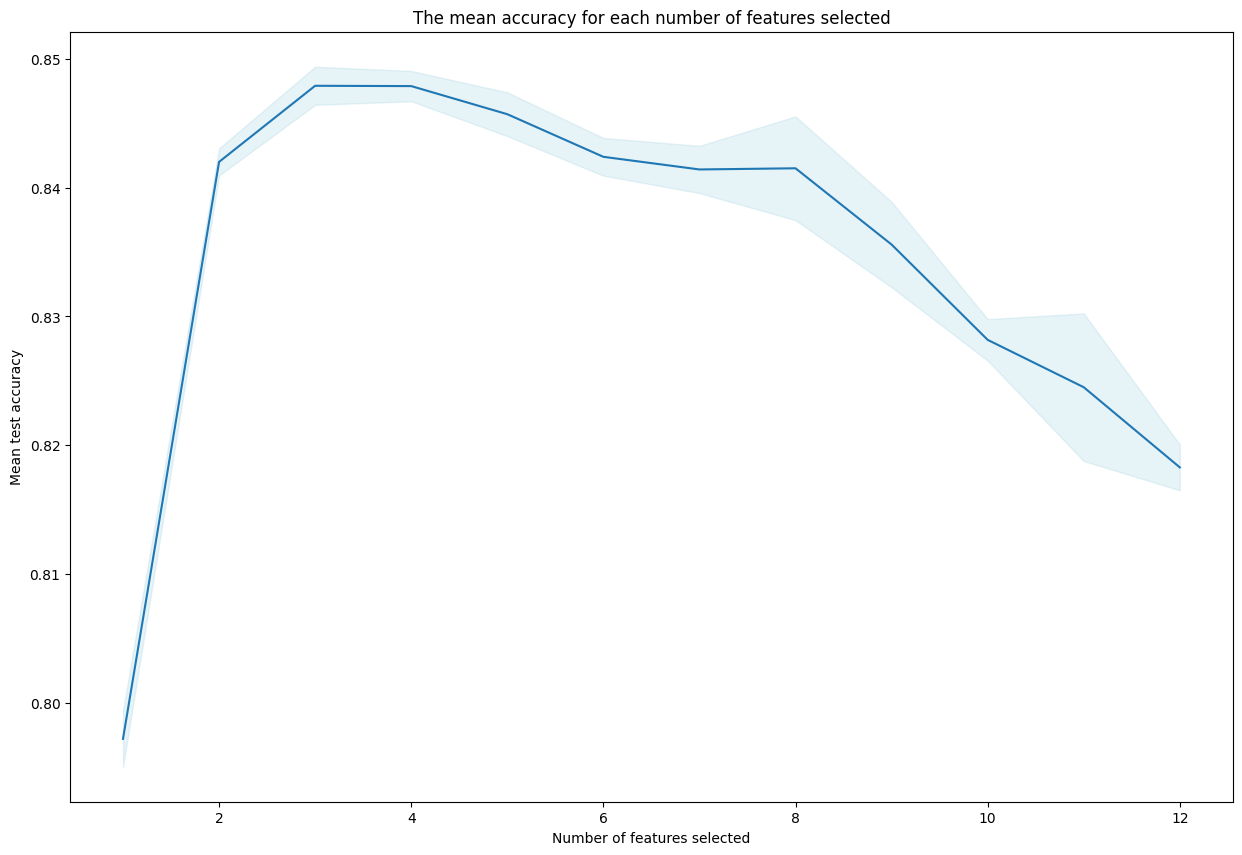

In [19]:
train2 = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")

# Data Transformations - Categorising all continuous variables
train2["Gender_Code"] = train2["Gender"].map({"Female": 0, "Male": 1})
train2[["France", "Spain", "Germany"]] = pd.get_dummies(train2["Geography"]).astype(int)
train2["CatAge"] = pd.cut(train2["Age"], bins=pd.qcut(train2["Age"], q=5).cat.categories).cat.codes
train2["CatBalance"] = 0
train2.loc[train2["Balance"] >= 50000, "CatBalance"] = 1
train2["CatEstimatedSalary"] = pd.cut(train2["EstimatedSalary"], bins=pd.qcut(train2["EstimatedSalary"], q=5).cat.categories).cat.codes
train2["CatCreditScore"] = pd.cut(train2["CreditScore"], bins=pd.qcut(train2["CreditScore"], q=5).cat.categories).cat.codes
columns_to_convert = ["HasCrCard", "IsActiveMember"]
train2[columns_to_convert] = train2[columns_to_convert].astype(int)

# Defining independent and target variables
x_var2 = ["CatCreditScore", "France", "Spain", "Germany", "Gender_Code", "CatAge", "Tenure", "CatBalance", 
         "NumOfProducts", "HasCrCard", "IsActiveMember", "CatEstimatedSalary"]
y_var2 = ["Exited"]
X2 = train2[x_var2]
y2 = train2[y_var2]

# Calling RFECV
rfecv2 = RFECV(estimator=model, step=1, min_features_to_select=1, cv=cv_split, scoring="accuracy", n_jobs=-1)
rfecv2.fit(X2, y2)

# Visualisation
plot_features_vs_cvscore(rfecv2)

### Thank you for reading this kernel :3 

Please note that most of the results and analysis done here was using Decision Tree models which may have a different way of calculating feature importances and handling features compared to other models. In addition, RFECV shines most when working on a high dimensional dataset, which the Titanic dataset really is not.